# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
import wandb
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from torchvision.datasets import MNIST
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [3]:
# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [4]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [5]:
#print(sys.executable)  # Vérifie l'interpréteur utilisé
print(torch.cuda.is_available())  # Vérifie l'accès à CUDA


True


Training epoch 9: 100%|██████████| 215/215 [00:32<00:00,  6.52it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.951     0.982     0.966       980
           1      0.970     0.984     0.977      1135
           2      0.935     0.922     0.928      1032
           3      0.919     0.926     0.923      1010
           4      0.931     0.944     0.937       982
           5      0.936     0.895     0.915       892
           6      0.947     0.950     0.948       958
           7      0.945     0.926     0.936      1028
           8      0.910     0.924     0.917       974
           9      0.927     0.916     0.921      1009

    accuracy                          0.938     10000
   macro avg      0.937     0.937     0.937     10000
weighted avg      0.938     0.938     0.937     10000



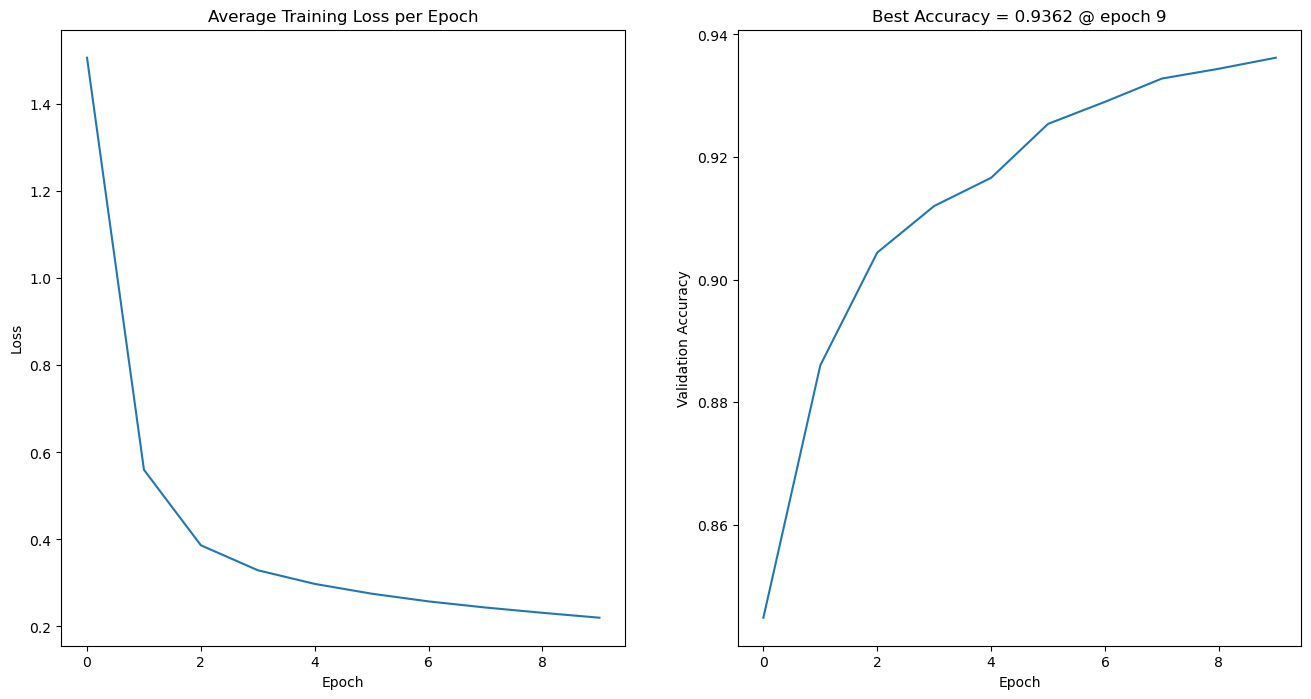

In [6]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
lr = 0.0001
batch_size = 256

#print(device)
writer = SummaryWriter()

# Architecture hyperparameters.
input_size = 28*28
width = 64
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Tensorboard logfile template.
model_type = 'MLP'
logdir = f'runs/{model_type}-width={width}-depth={depth}-bs={batch_size}-lr={lr}'

# Training loop.
losses_and_accs = []

for epoch in range(epochs):
    writer = SummaryWriter(logdir)
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Val/val', val_acc, epoch)
    losses_and_accs.append((loss, val_acc))
writer.flush()
writer.close()

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [7]:
# Your code here.

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten images
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_dataloader(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    # Split train into train and validation.

    val_size = 5000
    I = np.random.permutation(len(trainset))
    val_set = Subset(trainset, I[:val_size])
    train_set = Subset(trainset, I[val_size:])

    # Create DataLoaders for the subsets
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)  
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)  


    return train_loader, val_loader, test_loader

# Run the training and evaluation
train_loader, val_loader, test_loader = get_dataloader()
model = MLP()

In [8]:
def evaluate_model(model, dataloader, criterion, device):
    """Évalue le modèle sur un dataloader (train ou val)."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """Entraîne le modèle pour une époque complète."""
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device,
                patience, min_delta, delta_overfit, overfit_patience,
                model_name=None, wandb_project=None, wandb_run_name=None, save_dir="models"):
    
    # Préparation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    print(f"Training on {device}")

    # Variables de suivi
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = float("inf")
    overfit_epochs = 0
    stagnant_epochs = 0
    prev_val_loss = None
    actual_epochs = num_epochs

    # Init Weights & Biases
    if wandb_project:
        wandb.init(project=wandb_project, name=wandb_run_name, reinit=True)

    # Boucle d’entraînement
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Affichage
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}\n")

        # Logging wandb
        if wandb_project:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss, "train_acc": train_acc,
                "val_loss": val_loss, "val_acc": val_acc
            })

        # --- Early stopping & sauvegarde ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(save_dir, f"best_model_{model_name}.pth"))
        else:
            if val_loss > best_val_loss + delta_overfit:
                overfit_epochs += 1
                print(f"⚠️ Possible overfitting detected ({overfit_epochs}/{overfit_patience})")
                if overfit_epochs >= overfit_patience:
                    print(f"🛑 Stopping: Validation loss keeps increasing ({overfit_patience} epochs)")
                    actual_epochs = epoch + 1
                    break
            else:
                overfit_epochs = 0

        # Vérifier stagnation
        if prev_val_loss is not None:
            if abs(prev_val_loss - val_loss) < min_delta:
                stagnant_epochs += 1
                print(f"⚠️ Δ(val_loss) < {min_delta} for {stagnant_epochs} epochs")
                if stagnant_epochs >= patience:
                    print(f"🛑 Stopping: No significant improvement for {patience} epochs")
                    actual_epochs = epoch + 1
                    break
            else:
                stagnant_epochs = 0

        prev_val_loss = val_loss

    if wandb_project:
        wandb.finish()

    return train_losses, train_accuracies, val_losses, val_accuracies, actual_epochs

def plot_validation_curves(train_losses, train_acc, val_losses, val_acc):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train accuracy')
    plt.plot(val_acc, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Average Training Accuracy Per Epoch')
    plt.legend()

In [9]:
# Hyperparameters of a standard MLP
num_epochs = 50
learning_rate = 0.001

# Parameters for early stopping and overfitting detection
patience = 5
min_delta = 0.001
delta_overfit = 0.01
overfit_patience = 5

# WandB configuration
wandb_project = "DLA_MLP_Lab1"
wandb_run_name = "baseline_MLP"

# Creation and traning of MLP
mlp_model = MLP()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_losses, val_accuracies, mlp_epoch = train_model(
    mlp_model, train_loader, val_loader, optimizer, criterion, num_epochs, device,
    patience, min_delta, delta_overfit, overfit_patience,
    wandb_project=wandb_project, wandb_run_name=wandb_run_name, model_name="MLP"
)

Training on cuda


wandb: Currently logged in as: lorictongo (lorictongo-university-of-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/50
  Train: Loss=0.3538, Acc=0.8922
  Val:   Loss=0.1797, Acc=0.9472

Epoch 2/50
  Train: Loss=0.1622, Acc=0.9503
  Val:   Loss=0.1664, Acc=0.9514

Epoch 3/50
  Train: Loss=0.1199, Acc=0.9624
  Val:   Loss=0.1172, Acc=0.9632

Epoch 4/50
  Train: Loss=0.0945, Acc=0.9705
  Val:   Loss=0.1228, Acc=0.9628

Epoch 5/50
  Train: Loss=0.0803, Acc=0.9748
  Val:   Loss=0.0995, Acc=0.9686

Epoch 6/50
  Train: Loss=0.0703, Acc=0.9773
  Val:   Loss=0.1050, Acc=0.9702

Epoch 7/50
  Train: Loss=0.0607, Acc=0.9802
  Val:   Loss=0.1232, Acc=0.9644

⚠️ Possible overfitting detected (1/5)
Epoch 8/50
  Train: Loss=0.0563, Acc=0.9814
  Val:   Loss=0.1090, Acc=0.9696

Epoch 9/50
  Train: Loss=0.0476, Acc=0.9842
  Val:   Loss=0.0806, Acc=0.9754

Epoch 10/50
  Train: Loss=0.0431, Acc=0.9852
  Val:   Loss=0.1064, Acc=0.9742

⚠️ Possible overfitting detected (1/5)
Epoch 11/50
  Train: Loss=0.0388, Acc=0.9872
  Val:   Loss=0.0945, Acc=0.9762

⚠️ Possible overfitting detected (2/5)
Epoch 12/50
  Train: Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▅▆▆▇▇▇▇▇███████████
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▅▄▆▆▅▆▇▇▇████▇▇██▇
val_loss,█▇▄▄▂▃▄▃▁▃▂▁▂▂▁▃▂▂▃▃
epoch,20
train_acc,0.99218
train_loss,0.02217
val_acc,0.9764
val_loss,0.11411


  Test: Loss=0.7063, Accuracy=0.9142


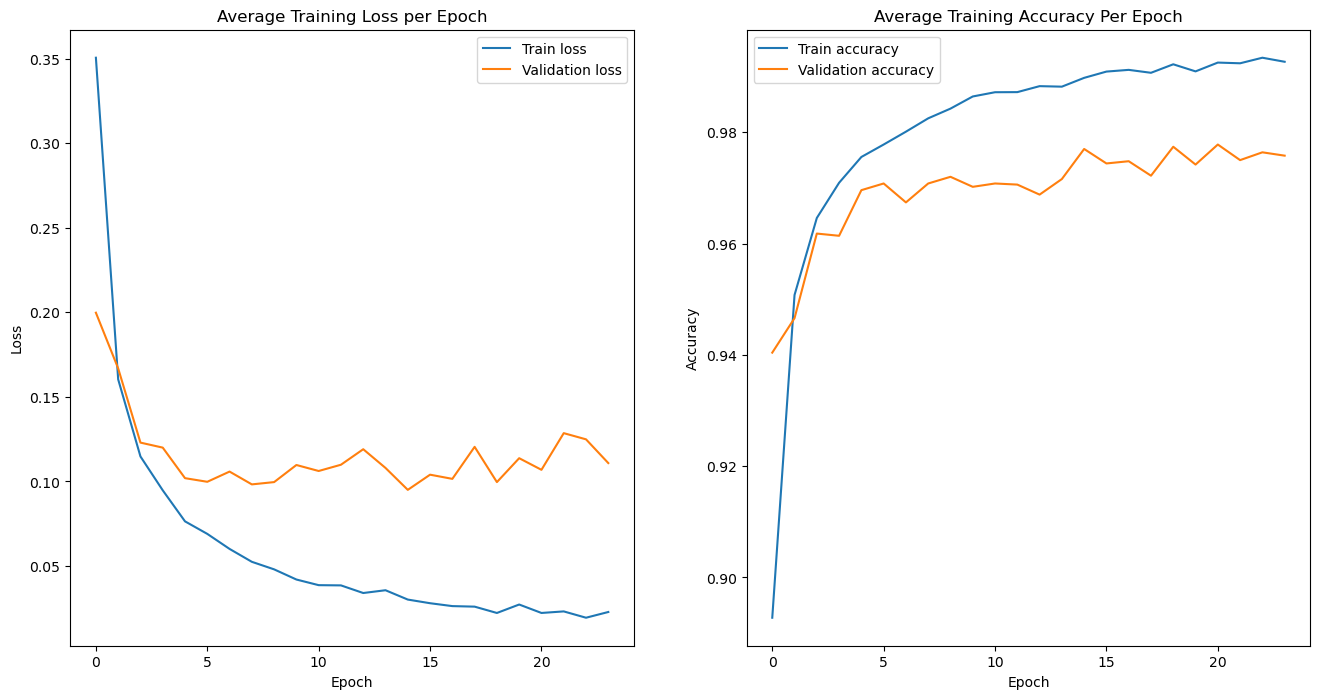

In [12]:
test_loss, test_acc = evaluate_model(model_mlp, test_loader, criterion, device)
print(f"  Test: Loss={test_loss:.4f}, Accuracy={test_acc:.4f}")

plot_validation_curves(train_losses, train_accuracies, val_losses, val_accuracies)

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [10]:
# Your code here.
# Définition d'un bloc résiduel MLP
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, in_features)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(in_features, in_features)

    def forward(self, x):
        identity = x  # Sauvegarde de l'entrée pour la connexion résiduelle
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out += identity  # Ajout de la connexion skip
        return self.relu(out)

# Définition du réseau MLP avec connexions résiduelles
class ResidualMLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=256, num_classes=10, num_blocks=3):
        super(ResidualMLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.residual_blocks = nn.Sequential(*[ResidualBlock(hidden_size) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28)       # flatten the input
        x = self.input_layer(x)
        x = self.residual_blocks(x)
        x = self.output_layer(x)
        return x




In [11]:
# Hyperparameters of a standard MLP
num_epochs = 50
learning_rate = 0.001

# Parameters for early stopping and overfitting detection
patience = 5
min_delta = 0.001
delta_overfit = 0.01
overfit_patience = 5

# WandB configuration
wandb_project = "DLA_MLP_Lab1"
wandb_run_name = "res_MLP"

# Creation and traning of MLP
res_model = ResidualMLP()
optimizer = torch.optim.Adam(res_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_losses, val_accuracies, mlp_epoch = train_model(
    res_model, train_loader, val_loader, optimizer, criterion, num_epochs, device,
    patience, min_delta, delta_overfit, overfit_patience,
    wandb_project=wandb_project, wandb_run_name=wandb_run_name, model_name="ResidualMLP"
)

Training on cuda


Epoch 1/50
  Train: Loss=0.2917, Acc=0.9103
  Val:   Loss=0.1506, Acc=0.9518

Epoch 2/50
  Train: Loss=0.1367, Acc=0.9567
  Val:   Loss=0.1365, Acc=0.9602

Epoch 3/50
  Train: Loss=0.1000, Acc=0.9680
  Val:   Loss=0.1226, Acc=0.9634

Epoch 4/50
  Train: Loss=0.0916, Acc=0.9709
  Val:   Loss=0.1411, Acc=0.9638

⚠️ Possible overfitting detected (1/5)
Epoch 5/50
  Train: Loss=0.0754, Acc=0.9759
  Val:   Loss=0.0909, Acc=0.9718

Epoch 6/50
  Train: Loss=0.0686, Acc=0.9775
  Val:   Loss=0.0978, Acc=0.9704

Epoch 7/50
  Train: Loss=0.0649, Acc=0.9788
  Val:   Loss=0.0886, Acc=0.9734

Epoch 8/50
  Train: Loss=0.0591, Acc=0.9812
  Val:   Loss=0.0978, Acc=0.9738

Epoch 9/50
  Train: Loss=0.0537, Acc=0.9829
  Val:   Loss=0.0943, Acc=0.9764

Epoch 10/50
  Train: Loss=0.0503, Acc=0.9842
  Val:   Loss=0.0998, Acc=0.9764

⚠️ Possible overfitting detected (1/5)
Epoch 11/50
  Train: Loss=0.0450, Acc=0.9861
  Val:   Loss=0.1197, Acc=0.9724

⚠️ Possible overfitting detected (2/5)
Epoch 12/50
  Train: Lo

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▅▆▇▇▇▇▇███████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▄▄▆▆▇▇██▇▇██▆
val_loss,█▇▅▇▂▃▂▃▂▃▅▃▁▃▆
epoch,15
train_acc,0.98693
train_loss,0.04183
val_acc,0.9708
val_loss,0.13271


  Test: Loss=0.1357, Accuracy=0.9680


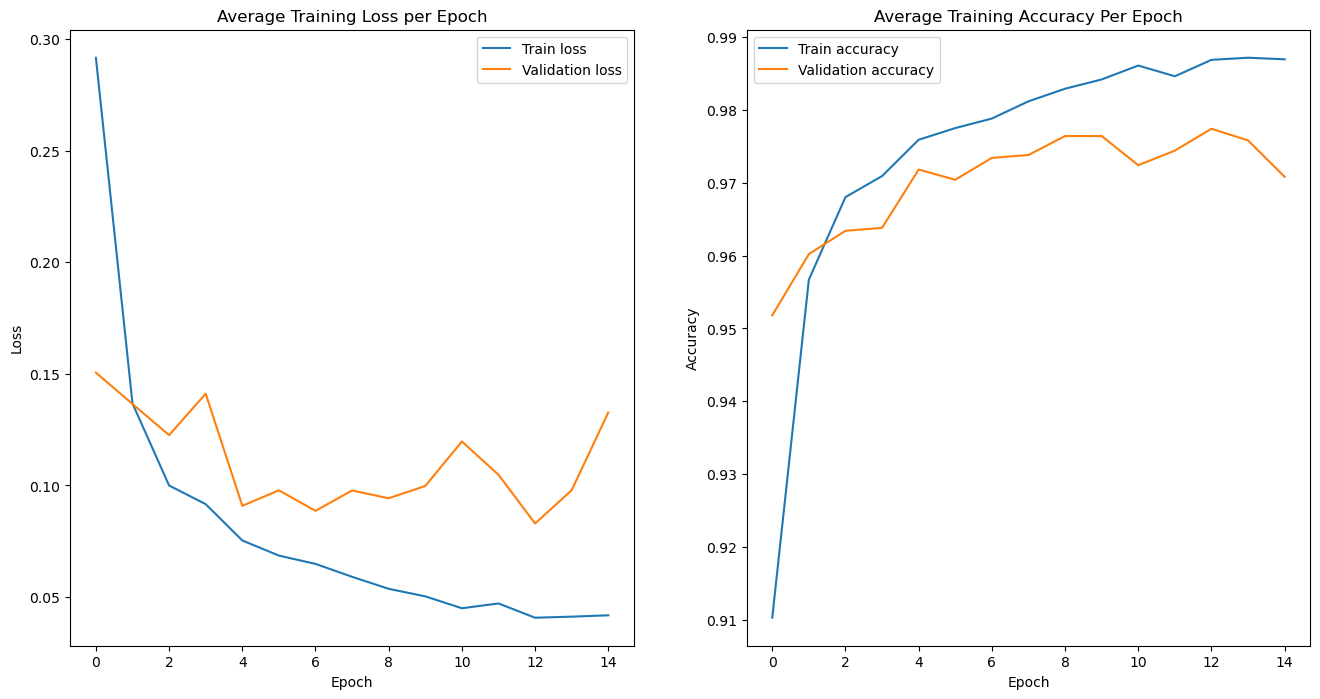

In [12]:
test_loss, test_acc = evaluate_model(res_model, test_loader, criterion, device)
print(f"  Test: Loss={test_loss:.4f}, Accuracy={test_acc:.4f}")

plot_validation_curves(train_losses, train_accuracies, val_losses, val_accuracies)

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [13]:
# Your code here.
# Définition du CNN simple

class BasicCNN(nn.Module):
    def __init__(self, in_channel, out_channel, num_classes, depth, hidden_dim):
        super(BasicCNN, self).__init__()

        layers = []

        for i in range(depth):
            layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2, 2))
            in_channel = out_channel
            out_channel *= 2  # double les filtres à chaque couche (64 → 128 → 256 ...)

        self.conv_layers = nn.Sequential(*layers)

        # CIFAR = 32x32. Chaque MaxPool(2,2) divise par 2.
        final_size = 32 // (2 ** depth)  # taille spatiale après depth pooling
        final_channels = in_channel

        self.fc1 = nn.Linear(final_channels * final_size * final_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [30]:
# Définition d'un bloc résiduel basique
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Ajustement de la dimension si nécessaire (downsampling)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity  # Ajout de la connexion skip
        return self.relu(out)

# Définition du ResNet simplifié
class ResNet(nn.Module):
    def __init__(self, in_channel, out_channel, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        
        self.layer1 = self._make_layer(out_channel, out_channel, num_blocks, stride=1)
        self.layer2 = self._make_layer(out_channel, out_channel*2, num_blocks, stride=2)
        self.layer3 = self._make_layer(out_channel*2, out_channel*4, num_blocks, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))        
        self.fc = nn.Linear(out_channel*4, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward_features(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.fc(x)
        return x

### Data Processing

In [15]:
# Transformation des données
transform_cifar10 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargement des datasets
batch_size = 128
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
train_loader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=batch_size, shuffle=True)

testset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)
test_loader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size, shuffle=False)

# Split train into train and validation.

val_size = int(len(trainset_cifar10) * 0.1)
I = np.random.permutation(len(trainset_cifar10))
val_set = Subset(trainset_cifar10, I[:val_size])
train_set = Subset(trainset_cifar10, I[val_size:])

# Create DataLoaders for the subsets
train_loader_cifar10 = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)  
val_loader_cifar10 = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


### Basic CNN Training

In [16]:
# Hyperparameters of a standard MLP
num_epochs = 50
learning_rate = 0.001

# Parameters for early stopping and overfitting detection
patience = 5
min_delta = 0.001
delta_overfit = 0.01
overfit_patience = 5

# WandB configuration
wandb_project = "DLA_MLP_Lab1"
wandb_run_name = "basic_CNN"

# Creation and traning of MLP

basic_cnn_model = BasicCNN(in_channel=3, out_channel=32, num_classes=10, depth=3, hidden_dim=256)
optimizer = torch.optim.Adam(basic_cnn_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_losses, val_accuracies, mlp_epoch = train_model(
    basic_cnn_model, train_loader_cifar10, val_loader_cifar10, optimizer, criterion, num_epochs, device,
    patience, min_delta, delta_overfit, overfit_patience,
    wandb_project=wandb_project, wandb_run_name=wandb_run_name, model_name="BasicCNN"
)

Training on cuda


Epoch 1/50
  Train: Loss=1.6053, Acc=0.4128
  Val:   Loss=1.4200, Acc=0.4832

Epoch 2/50
  Train: Loss=1.2608, Acc=0.5459
  Val:   Loss=1.1186, Acc=0.6012

Epoch 3/50
  Train: Loss=1.0644, Acc=0.6215
  Val:   Loss=0.9714, Acc=0.6596

Epoch 4/50
  Train: Loss=0.9596, Acc=0.6632
  Val:   Loss=0.9116, Acc=0.6738

Epoch 5/50
  Train: Loss=0.8809, Acc=0.6892
  Val:   Loss=0.8531, Acc=0.7040

Epoch 6/50
  Train: Loss=0.8364, Acc=0.7084
  Val:   Loss=0.8291, Acc=0.7132

Epoch 7/50
  Train: Loss=0.7893, Acc=0.7246
  Val:   Loss=0.7611, Acc=0.7334

Epoch 8/50
  Train: Loss=0.7542, Acc=0.7361
  Val:   Loss=0.7440, Acc=0.7502

Epoch 9/50
  Train: Loss=0.7296, Acc=0.7467
  Val:   Loss=0.7415, Acc=0.7466

Epoch 10/50
  Train: Loss=0.7005, Acc=0.7535
  Val:   Loss=0.7251, Acc=0.7526

Epoch 11/50
  Train: Loss=0.6835, Acc=0.7625
  Val:   Loss=0.7225, Acc=0.7516

Epoch 12/50
  Train: Loss=0.6651, Acc=0.7694
  Val:   Loss=0.6850, Acc=0.7576

Epoch 13/50
  Train: Loss=0.6496, Acc=0.7739
  Val:   Loss=0.

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇█████████████
val_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_acc,0.8506
train_loss,0.431
val_acc,0.8054
val_loss,0.58587


### CNN with Residual Connection Training

In [32]:
# Entraînement du ResNet avec connexions résiduelles

# Hyperparameters of a standard MLP
num_epochs = 50
learning_rate = 0.001

# Parameters for early stopping and overfitting detection
patience = 5
min_delta = 0.001
delta_overfit = 0.01
overfit_patience = 5

# WandB configuration
wandb_project = "DLA_MLP_Lab1"
wandb_run_name = "ResNet"

# Creation and traning of MLP
resnet_model = ResNet(in_channel=3, out_channel=32, num_blocks=4, num_classes=10)
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_losses, val_accuracies, mlp_epoch = train_model(
    resnet_model, train_loader_cifar10, val_loader_cifar10, optimizer, criterion, num_epochs, device,
    patience, min_delta, delta_overfit, overfit_patience,
    wandb_project=wandb_project, wandb_run_name=wandb_run_name, model_name="ResNet"
)

Training on cuda


Epoch 1/50
  Train: Loss=1.4637, Acc=0.4581
  Val:   Loss=1.3697, Acc=0.5306

Epoch 2/50
  Train: Loss=1.0215, Acc=0.6333
  Val:   Loss=1.0854, Acc=0.6270

Epoch 3/50
  Train: Loss=0.8186, Acc=0.7095
  Val:   Loss=1.0636, Acc=0.6566

Epoch 4/50
  Train: Loss=0.6932, Acc=0.7587
  Val:   Loss=0.7756, Acc=0.7418

Epoch 5/50
  Train: Loss=0.6062, Acc=0.7897
  Val:   Loss=0.6323, Acc=0.7860

Epoch 6/50
  Train: Loss=0.5536, Acc=0.8074
  Val:   Loss=0.6099, Acc=0.7876

Epoch 7/50
  Train: Loss=0.5051, Acc=0.8255
  Val:   Loss=0.6351, Acc=0.7890

⚠️ Possible overfitting detected (1/5)
Epoch 8/50
  Train: Loss=0.4671, Acc=0.8373
  Val:   Loss=0.5776, Acc=0.8080

Epoch 9/50
  Train: Loss=0.4328, Acc=0.8507
  Val:   Loss=0.5330, Acc=0.8200

Epoch 10/50
  Train: Loss=0.4037, Acc=0.8597
  Val:   Loss=0.4884, Acc=0.8306

Epoch 11/50
  Train: Loss=0.3813, Acc=0.8674
  Val:   Loss=0.4780, Acc=0.8382

Epoch 12/50
  Train: Loss=0.3580, Acc=0.8762
  Val:   Loss=0.4741, Acc=0.8366

Epoch 13/50
  Train: L

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▆▆▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch,20
train_acc,0.91716
train_loss,0.23618
val_acc,0.8532
val_loss,0.43383


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

#### Chargement de CIFAR-100

In [18]:
# Chargement des datasets

transform_cifar100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128
trainset_cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar100)
testset_cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar100)



# Split train into train and validation.

val_size = int(len(trainset_cifar100) * 0.1)
I = np.random.permutation(len(trainset_cifar100))
val_set_cifar100 = Subset(trainset_cifar100, I[:val_size])
train_set_cifar100 = Subset(trainset_cifar100, I[val_size:])

# Create DataLoaders for the subsets
train_loader_cifar100 = torch.utils.data.DataLoader(train_set_cifar100, batch_size=batch_size, shuffle=True)  
val_loader_cifar100 = torch.utils.data.DataLoader(val_set_cifar100, batch_size=batch_size, shuffle=False)
test_loader_cifar100 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Pre-trained ResNet

In [33]:
num_classes = 10         
out_channel = 32       
in_channel = 3
num_blocks=4  

# Load the model from Exercise 1.3 (pre-trained on CIFAR-10)
resnet_model_100 = ResNet(in_channel, out_channel, num_blocks, num_classes)

model_name="ResNet"

# Load pre-trained weights
resnet_model_100.load_state_dict(torch.load(f"models/best_model_{model_name}.pth"))

# Freeze all layers
for param in resnet_model_100.parameters():
    param.requires_grad = False

resnet_model_100.eval()

C:\Users\loric\AppData\Local\Temp\ipykernel_6720\826545324.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model_100.load_state_dict(torch.load(f"models/best_mod

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

#### Extraire les features (enlever le classifieur)

In [34]:
resnet_model_100.eval()
resnet_model_100.to(device)

features_train = []
labels_train = []

# Extract features from train set
with torch.no_grad():
    for inputs, labels in train_loader_cifar100:
        inputs = inputs.to(device)
        feats = resnet_model_100.forward_features(inputs)
        features_train.append(feats.cpu().numpy())
        labels_train.append(labels.numpy())

features_train = np.concatenate(features_train)
labels_train = np.concatenate(labels_train)

# Extract features from test set
features_test = []
labels_test = []

with torch.no_grad():
    for input, labels in test_loader_cifar100:
        input = input.to(device)
        feats = resnet_model_100.forward_features(input)
        features_test.append(feats.cpu().numpy())
        labels_test.append(labels.numpy())

features_test = np.concatenate(features_test)
labels_test = np.concatenate(labels_test)

In [35]:
# Standardize features
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)


### Entraîner un classifieur classique

#### K-Nearest Neighbor

In [36]:

# Example 2: KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(features_train, labels_train)
predictions_knn = knn_clf.predict(features_test)
knn_acc = accuracy_score(labels_test, predictions_knn)
print(f"KNN Baseline Accuracy: {knn_acc:.2f}")

KNN Baseline Accuracy: 0.02


### Fine-tuning complet
Ici on remplace le classifieur par un nouveau de 100 classes.

On dégèle progressivement les couches.

In [41]:
resnet_model_100.fc = nn.Linear(resnet_model_100.fc.in_features, 100).to(device)  # Nouveau classifieur

# Geler toutes les couches
for param in resnet_model_100.parameters():
    param.requires_grad = False

# Dégeler uniquement le classifieur
for param in resnet_model_100.fc.parameters():
    param.requires_grad = True

resnet_model_100.train()

optimizer = torch.optim.Adam(resnet_model_100.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training Loop
train_losses_ft, val_losses_ft, epochs_ft = train_model(resnet_model_100, train_loader_cifar100, val_loader_cifar100,
    optimizer, criterion, num_epochs=50, device=device, patience=5, min_delta=0.001,
    delta_overfit=0.01, overfit_patience=5, wandb_project="DLA_MLP_Lab1",
    wandb_run_name="ResNet_on_CIFAR100", model_name="ResNet_FT"
)

Training on cuda


Epoch 1/50
  Train: Loss=4.4786, Acc=0.0309
  Val:   Loss=4.1796, Acc=0.0556

Epoch 2/50
  Train: Loss=4.0157, Acc=0.0842
  Val:   Loss=3.8840, Acc=0.1136

Epoch 3/50
  Train: Loss=3.7903, Acc=0.1261
  Val:   Loss=3.7129, Acc=0.1430

Epoch 4/50
  Train: Loss=3.6513, Acc=0.1514
  Val:   Loss=3.6105, Acc=0.1622

Epoch 5/50
  Train: Loss=3.5546, Acc=0.1665
  Val:   Loss=3.5337, Acc=0.1702

Epoch 6/50
  Train: Loss=3.4862, Acc=0.1774
  Val:   Loss=3.4725, Acc=0.1776

Epoch 7/50
  Train: Loss=3.4316, Acc=0.1850
  Val:   Loss=3.4184, Acc=0.1864

Epoch 8/50
  Train: Loss=3.3861, Acc=0.1942
  Val:   Loss=3.3771, Acc=0.1942

Epoch 9/50
  Train: Loss=3.3514, Acc=0.1980
  Val:   Loss=3.3480, Acc=0.2022

Epoch 10/50
  Train: Loss=3.3195, Acc=0.2039
  Val:   Loss=3.3218, Acc=0.2096

Epoch 11/50
  Train: Loss=3.2926, Acc=0.2076
  Val:   Loss=3.3065, Acc=0.2090

Epoch 12/50
  Train: Loss=3.2704, Acc=0.2118
  Val:   Loss=3.2687, Acc=0.2136

Epoch 13/50
  Train: Loss=3.2480, Acc=0.2145
  Val:   Loss=3.

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▃▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_acc,0.27689
train_loss,2.92971
val_acc,0.2724
val_loss,2.95747


ValueError: too many values to unpack (expected 3)

### Evaluation of the Fine tuning

### Comparison plot of KNN, SVM and Fine-Tuning

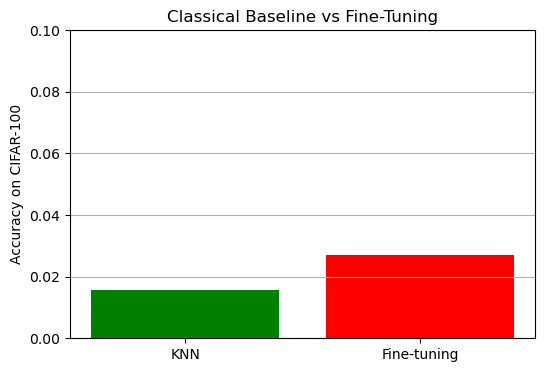

In [47]:
model_names = ["KNN", "Fine-tuning"]
accuracies = [knn_acc, acc_ft]

plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies, color=["green", "red", "yellow"]) 

plt.ylim(0, 0.1) # Axe des y entre 0 et 1
plt.ylabel("Accuracy on CIFAR-100")
plt.title("Classical Baseline vs Fine-Tuning")
plt.grid(axis='y') # Affiche les lignes de la grille horizontale

plt.show()

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.